In [14]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [15]:
def load_and_profile_benin_malanville():
    """Load and perform initial profiling of Benin-Malanville data"""

    print("🇧🇯 BENIN-MALANVILLE SOLAR DATA EDA")
    print("=" * 60)

    # Load the dataset
    try:
        df = pd.read_csv('benin-malanville.csv')
        print(f" Dataset loaded successfully: {df.shape}")
    except FileNotFoundError:
        print(" File not found. Trying alternative paths...")
        try:
            df = pd.read_csv('benin-malanville.csv')
            print(f" Dataset loaded successfully: {df.shape}")
        except:
            print(" Could not load benin-malanville.csv")
            return None

    # Initial data inspection
    print(f"\n DATASET OVERVIEW:")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {len(df.columns)}")

    print(f"\n COLUMN NAMES:")
    print(df.columns.tolist())

    print(f"\n DATA TYPES:")
    print(df.dtypes)

    print(f"\n SAMPLE DATA (first 3 rows):")
    print(df.head(3))

    return df

# Load the data
df_benin = load_and_profile_benin_malanville()

🇧🇯 BENIN-MALANVILLE SOLAR DATA EDA
 Dataset loaded successfully: (525600, 19)

 DATASET OVERVIEW:
   Shape: (525600, 19)
   Columns: 19

 COLUMN NAMES:
['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']

 DATA TYPES:
Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object

 SAMPLE DATA (first 3 rows):
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-08-09 00:01 -1.2 -0.2 -1.1   0.0   0.0  26.2  93.4  0.0   

In [16]:
def comprehensive_profiling(df):
    """Perform comprehensive data profiling"""

    print("\n" + "=" * 60)
    print("📈 COMPREHENSIVE DATA PROFILING")
    print("=" * 60)

    # Summary statistics for numeric columns
    print("\n SUMMARY STATISTICS (numeric columns):")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(df[numeric_cols].describe())

    # Missing value analysis
    print("\n MISSING VALUE ANALYSIS:")
    missing_count = df.isna().sum()
    missing_pct = (df.isna().sum() / len(df)) * 100

    missing_df = pd.DataFrame({
        'Missing_Count': missing_count,
        'Missing_Percentage': missing_pct
    }).sort_values('Missing_Percentage', ascending=False)

    print(missing_df[missing_df['Missing_Count'] > 0])

    # Flag columns with >5% missing values
    high_missing = missing_pct[missing_pct > 5]
    if len(high_missing) > 0:
        print(f"\n  COLUMNS WITH >5% MISSING VALUES:")
        for col, pct in high_missing.items():
            print(f"   {col}: {pct:.2f}%")
    else:
        print(f"\n No columns with >5% missing values")

    return missing_df, numeric_cols

# Run profiling
if df_benin is not None:
    missing_report, numeric_cols = comprehensive_profiling(df_benin)


📈 COMPREHENSIVE DATA PROFILING

 SUMMARY STATISTICS (numeric columns):
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.0

In [17]:
def detect_and_clean_outliers(df):
    """Detect outliers and perform data cleaning"""

    print("\n" + "=" * 60)
    print(" OUTLIER DETECTION & DATA CLEANING")
    print("=" * 60)

    df_clean = df.copy()

    # Key solar parameters for outlier detection
    solar_params = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust', 'Tamb', 'RH', 'BP']
    available_params = [col for col in solar_params if col in df_clean.columns]

    print(f" Cleaning {len(available_params)} solar parameters: {available_params}")

    # Create outlier flags dataframe
    outlier_flags = pd.DataFrame(index=df_clean.index)
    outlier_summary = {}

    # Detect outliers using Z-score method (|Z| > 3)
    for col in available_params:
        if col in numeric_cols:
            # Calculate Z-scores (ignore NaN values)
            data = df_clean[col].dropna()
            if len(data) > 0:
                z_scores = np.abs(stats.zscore(data))
                outlier_mask = z_scores > 3

                # Create flag column
                outlier_flags[f'{col}_outlier'] = False
                outlier_flags.loc[data.index[outlier_mask], f'{col}_outlier'] = True

                outlier_count = outlier_mask.sum()
                outlier_pct = (outlier_count / len(data)) * 100
                outlier_summary[col] = {'count': outlier_count, 'percentage': outlier_pct}

                print(f"   {col}: {outlier_count} outliers ({outlier_pct:.2f}%)")

    # Add overall cleaning flag
    df_clean['cleaning_flag'] = outlier_flags.any(axis=1)
    total_outliers = df_clean['cleaning_flag'].sum()
    print(f"\n TOTAL ROWS FLAGGED FOR CLEANING: {total_outliers} ({total_outliers/len(df_clean)*100:.2f}%)")

    # Handle missing values - impute with median
    print(f"\n HANDLING MISSING VALUES:")
    for col in available_params:
        if col in df_clean.columns and df_clean[col].isna().sum() > 0:
            missing_before = df_clean[col].isna().sum()
            median_val = df_clean[col].median()

            # Store original values before imputation
            df_clean[f'{col}_original'] = df_clean[col]

            # Impute missing values with median
            df_clean[col].fillna(median_val, inplace=True)

            print(f"   {col}: Imputed {missing_before} missing values with median {median_val:.2f}")

    # Remove extreme outliers for key irradiance parameters
    key_irradiance = ['GHI', 'DNI', 'DHI']
    initial_count = len(df_clean)

    for param in key_irradiance:
        if param in df_clean.columns:
            Q1 = df_clean[param].quantile(0.25)
            Q3 = df_clean[param].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Count extreme outliers
            extreme_outliers = ((df_clean[param] < lower_bound) | (df_clean[param] > upper_bound)).sum()
            if extreme_outliers > 0:
                print(f"   {param}: {extreme_outliers} extreme outliers (IQR method)")

    print(f"\n CLEANING COMPLETED")
    print(f"   Original dataset: {len(df)} rows")
    print(f"   Cleaned dataset: {len(df_clean)} rows")

    return df_clean, outlier_flags

# Perform cleaning
if df_benin is not None:
    df_clean, outlier_flags = detect_and_clean_outliers(df_benin)


 OUTLIER DETECTION & DATA CLEANING
 Cleaning 10 solar parameters: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust', 'Tamb', 'RH', 'BP']
   GHI: 89 outliers (0.02%)
   DNI: 0 outliers (0.00%)
   DHI: 3738 outliers (0.71%)
   ModA: 27 outliers (0.01%)
   ModB: 63 outliers (0.01%)
   WS: 3109 outliers (0.59%)
   WSgust: 3500 outliers (0.67%)
   Tamb: 0 outliers (0.00%)
   RH: 0 outliers (0.00%)
   BP: 865 outliers (0.16%)

 TOTAL ROWS FLAGGED FOR CLEANING: 8551 (1.63%)

 HANDLING MISSING VALUES:
   GHI: 145 extreme outliers (IQR method)
   DNI: 15196 extreme outliers (IQR method)
   DHI: 8733 extreme outliers (IQR method)

 CLEANING COMPLETED
   Original dataset: 525600 rows
   Cleaned dataset: 525600 rows



TIME SERIES ANALYSIS
Using timestamp column: Timestamp


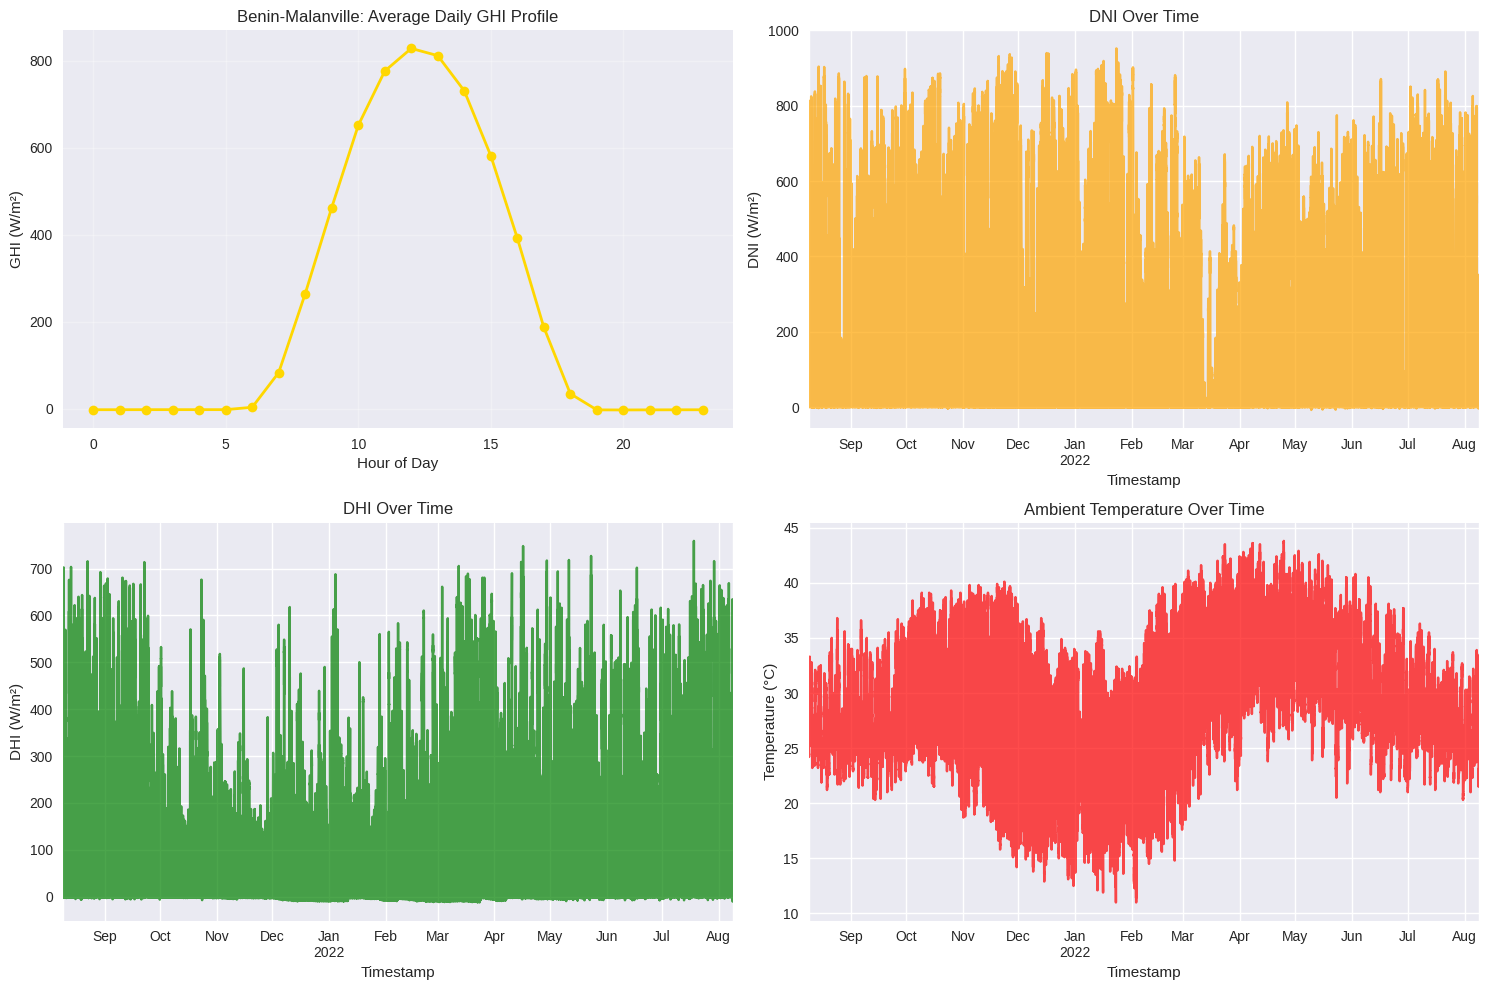

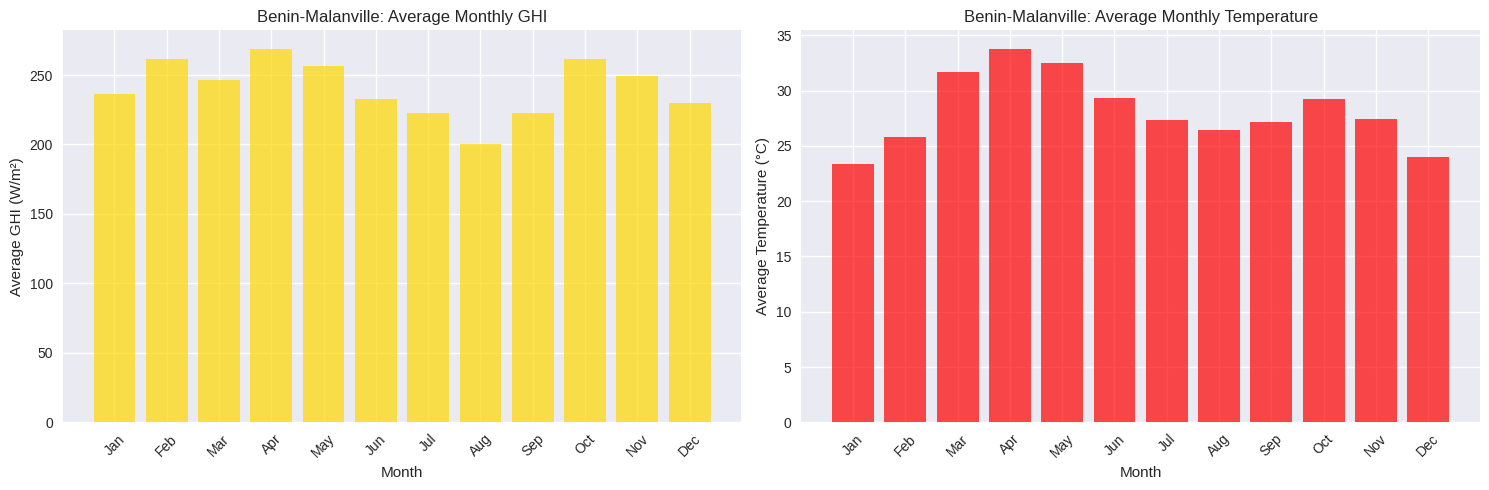

In [18]:
def time_series_analysis(df):
    """Perform comprehensive time series analysis"""

    print("\n" + "=" * 60)
    print("TIME SERIES ANALYSIS")
    print("=" * 60)

    # Identify timestamp column
    timestamp_candidates = ['Timestamp', 'timestamp', 'Date', 'date', 'time', 'Time', 'DateTime']
    timestamp_col = None

    for col in timestamp_candidates:
        if col in df.columns:
            timestamp_col = col
            break

    if not timestamp_col:
        print(" No timestamp column found - creating synthetic timeline")
        timestamp_col = 'Index'
        df[timestamp_col] = df.index
    else:
        print(f"Using timestamp column: {timestamp_col}")
        # Convert to datetime
        try:
            df[timestamp_col] = pd.to_datetime(df[timestamp_col])
        except:
            print(" Could not convert to datetime - using as is")

    # Set timestamp as index for time series analysis
    df_temp = df.set_index(timestamp_col) if timestamp_col != 'Index' else df

    # Plot time series for key parameters
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # GHI over time
    if 'GHI' in df.columns:
        if hasattr(df_temp.index, 'hour'):  # If we have proper datetime index
            # Daily pattern
            daily_pattern = df_temp.groupby(df_temp.index.hour)['GHI'].mean()
            axes[0,0].plot(daily_pattern.index, daily_pattern.values, marker='o', linewidth=2, color='gold')
            axes[0,0].set_xlabel('Hour of Day')
            axes[0,0].set_ylabel('GHI (W/m²)')
            axes[0,0].set_title('Benin-Malanville: Average Daily GHI Profile')
            axes[0,0].grid(True, alpha=0.3)
        else:
            df_temp['GHI'].plot(ax=axes[0,0], alpha=0.7, color='gold')
            axes[0,0].set_ylabel('GHI (W/m²)')
            axes[0,0].set_title('GHI Over Time')

    # DNI over time
    if 'DNI' in df.columns:
        df_temp['DNI'].plot(ax=axes[0,1], alpha=0.7, color='orange')
        axes[0,1].set_ylabel('DNI (W/m²)')
        axes[0,1].set_title('DNI Over Time')

    # DHI over time
    if 'DHI' in df.columns:
        df_temp['DHI'].plot(ax=axes[1,0], alpha=0.7, color='green')
        axes[1,0].set_ylabel('DHI (W/m²)')
        axes[1,0].set_title('DHI Over Time')

    # Temperature over time
    if 'Tamb' in df.columns:
        df_temp['Tamb'].plot(ax=axes[1,1], alpha=0.7, color='red')
        axes[1,1].set_ylabel('Temperature (°C)')
        axes[1,1].set_title('Ambient Temperature Over Time')

    plt.tight_layout()
    plt.show()

    # Monthly analysis if we have proper datetime
    if hasattr(df_temp.index, 'month') and 'GHI' in df.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Monthly GHI pattern
        monthly_ghi = df_temp.groupby(df_temp.index.month)['GHI'].mean()
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        ax1.bar(range(1, len(monthly_ghi)+1), monthly_ghi.values, color='gold', alpha=0.7)
        ax1.set_xlabel('Month')
        ax1.set_ylabel('Average GHI (W/m²)')
        ax1.set_title('Benin-Malanville: Average Monthly GHI')
        ax1.set_xticks(range(1, 13))
        ax1.set_xticklabels(months[:len(monthly_ghi)], rotation=45)

        # Monthly temperature pattern
        if 'Tamb' in df.columns:
            monthly_temp = df_temp.groupby(df_temp.index.month)['Tamb'].mean()
            ax2.bar(range(1, len(monthly_temp)+1), monthly_temp.values, color='red', alpha=0.7)
            ax2.set_xlabel('Month')
            ax2.set_ylabel('Average Temperature (°C)')
            ax2.set_title('Benin-Malanville: Average Monthly Temperature')
            ax2.set_xticks(range(1, 13))
            ax2.set_xticklabels(months[:len(monthly_temp)], rotation=45)

        plt.tight_layout()
        plt.show()

# Run time series analysis
if df_benin is not None:
    time_series_analysis(df_clean)


 CLEANING IMPACT ANALYSIS


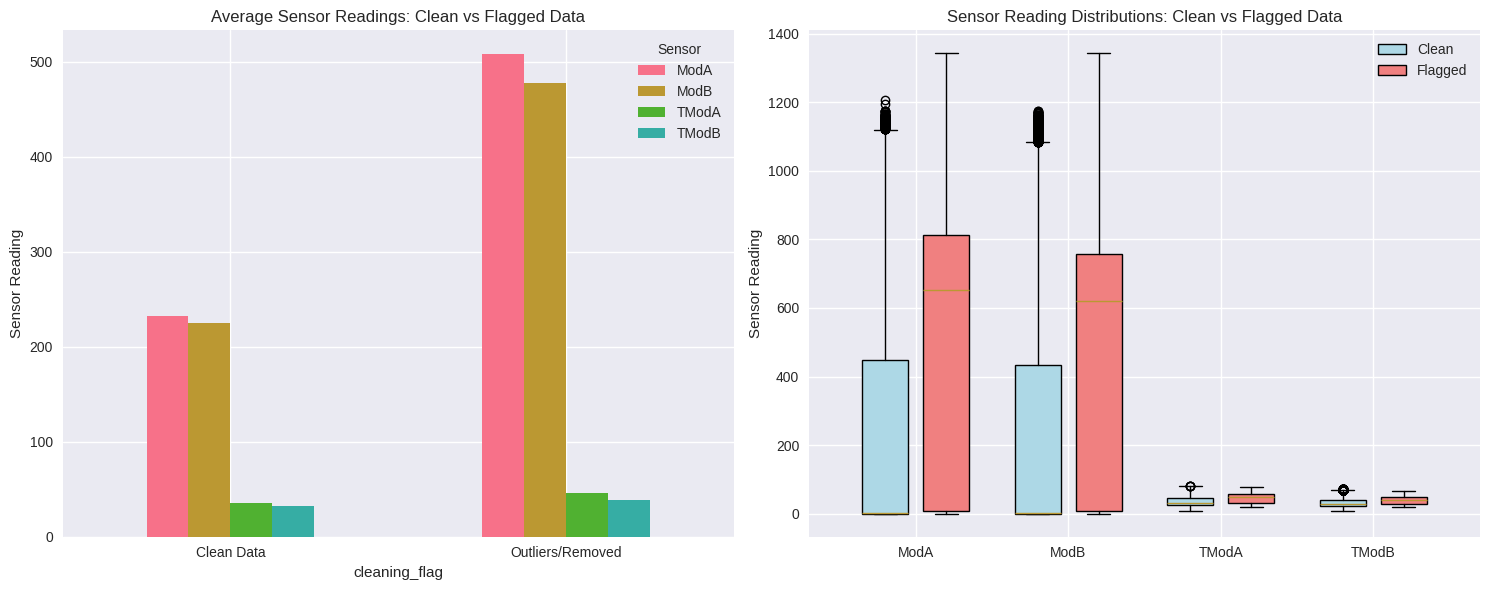


 STATISTICAL COMPARISON (Clean vs Flagged Data):
   ModA: Clean=232.11, Flagged=507.48, Diff=+118.6%
   ModB: Clean=224.77, Flagged=477.74, Diff=+112.5%
   TModA: Clean=35.08, Flagged=45.57, Diff=+29.9%
   TModB: Clean=32.36, Flagged=38.94, Diff=+20.3%


In [19]:
def cleaning_impact_analysis(df_clean):
    """Analyze the impact of data cleaning"""

    print("\n" + "=" * 60)
    print(" CLEANING IMPACT ANALYSIS")
    print("=" * 60)

    if 'cleaning_flag' not in df_clean.columns:
        print(" No cleaning flags found")
        return

    # Compare sensor readings before and after cleaning
    sensor_cols = [col for col in ['ModA', 'ModB', 'TModA', 'TModB'] if col in df_clean.columns]

    if sensor_cols:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Average values comparison
        clean_comparison = df_clean.groupby('cleaning_flag')[sensor_cols].mean()

        clean_comparison.plot(kind='bar', ax=axes[0])
        axes[0].set_title('Average Sensor Readings: Clean vs Flagged Data')
        axes[0].set_ylabel('Sensor Reading')
        axes[0].legend(title='Sensor')
        axes[0].set_xticklabels(['Clean Data', 'Outliers/Removed'], rotation=0)

        # Distribution comparison using boxplot
        clean_data = df_clean[~df_clean['cleaning_flag']][sensor_cols]
        flagged_data = df_clean[df_clean['cleaning_flag']][sensor_cols]

        positions = range(1, len(sensor_cols) + 1)
        bp1 = axes[1].boxplot([clean_data[col].dropna() for col in sensor_cols],
                             positions=[p - 0.2 for p in positions],
                             widths=0.3, patch_artist=True)
        bp2 = axes[1].boxplot([flagged_data[col].dropna() for col in sensor_cols],
                             positions=[p + 0.2 for p in positions],
                             widths=0.3, patch_artist=True)

        # Color the boxes
        for box in bp1['boxes']:
            box.set_facecolor('lightblue')
        for box in bp2['boxes']:
            box.set_facecolor('lightcoral')

        axes[1].set_title('Sensor Reading Distributions: Clean vs Flagged Data')
        axes[1].set_xticks(positions)
        axes[1].set_xticklabels(sensor_cols)
        axes[1].legend([bp1["boxes"][0], bp2["boxes"][0]], ['Clean', 'Flagged'], loc='upper right')
        axes[1].set_ylabel('Sensor Reading')

        plt.tight_layout()
        plt.show()

        # Statistical comparison
        print("\n STATISTICAL COMPARISON (Clean vs Flagged Data):")
        for col in sensor_cols:
            clean_mean = clean_data[col].mean()
            flagged_mean = flagged_data[col].mean()
            difference = ((flagged_mean - clean_mean) / clean_mean) * 100

            print(f"   {col}: Clean={clean_mean:.2f}, Flagged={flagged_mean:.2f}, Diff={difference:+.1f}%")

# Analyze cleaning impact
if df_benin is not None:
    cleaning_impact_analysis(df_clean)


 CORRELATION & RELATIONSHIP ANALYSIS


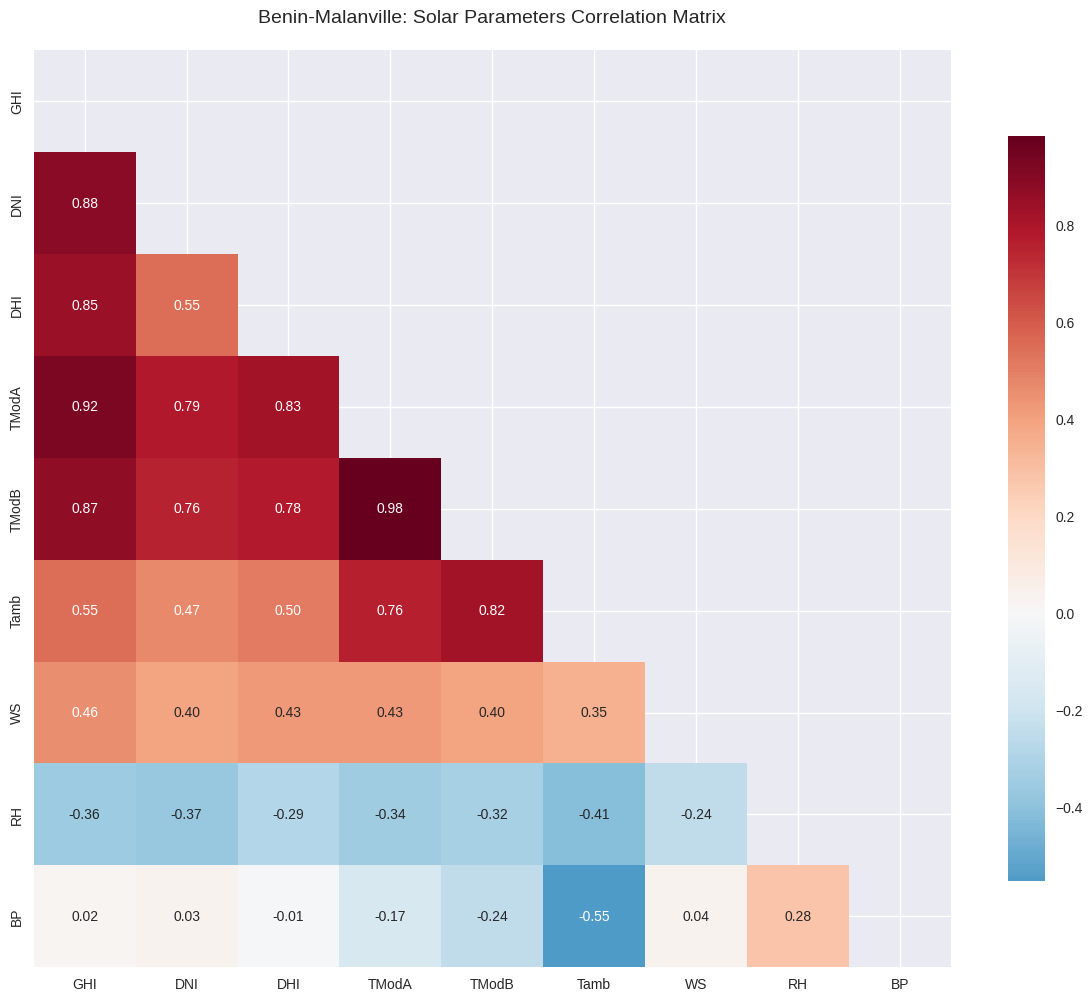

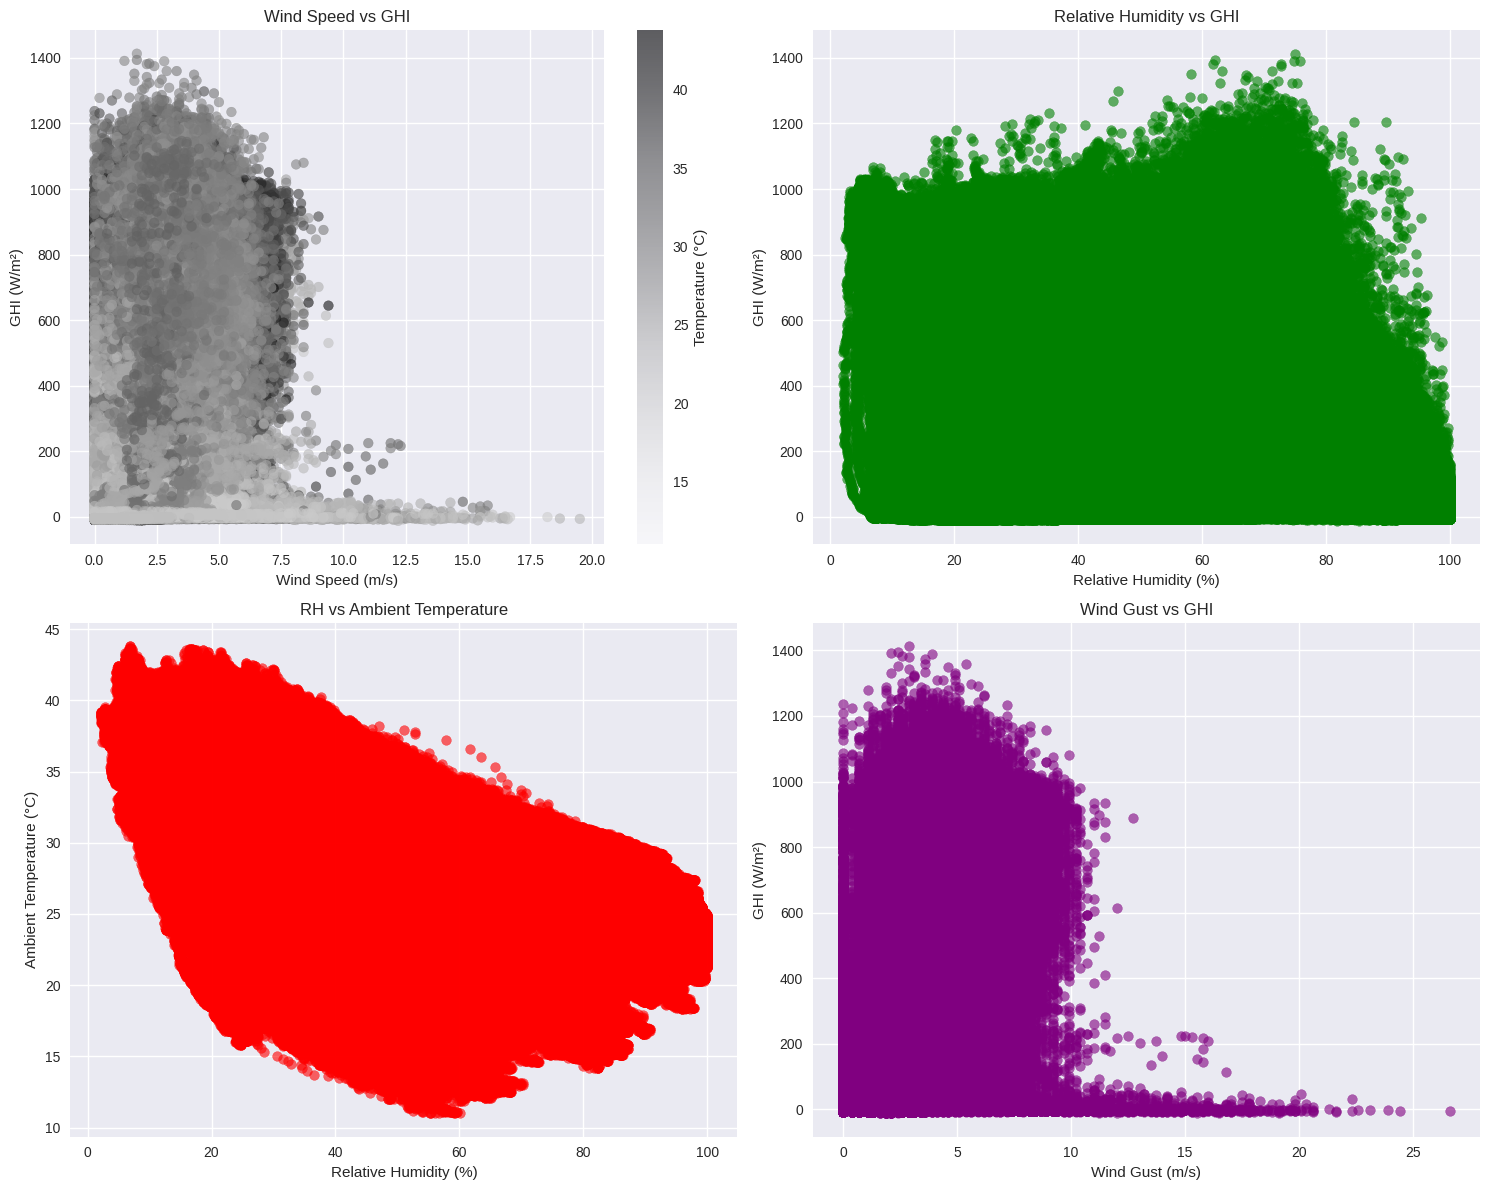


💡 STRONG CORRELATIONS (|r| > 0.7):
   GHI vs DNI: r = 0.882
   GHI vs DHI: r = 0.850
   GHI vs TModA: r = 0.920
   GHI vs TModB: r = 0.874
   DNI vs TModA: r = 0.790
   DNI vs TModB: r = 0.756
   DHI vs TModA: r = 0.825
   DHI vs TModB: r = 0.778
   TModA vs TModB: r = 0.983
   TModA vs Tamb: r = 0.762
   TModB vs Tamb: r = 0.823


In [20]:
def correlation_relationship_analysis(df):
    """Perform correlation and relationship analysis"""

    print("\n" + "=" * 60)
    print(" CORRELATION & RELATIONSHIP ANALYSIS")
    print("=" * 60)

    # Select key solar parameters for correlation analysis
    solar_corr_params = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'WS', 'RH', 'BP']
    available_corr_params = [col for col in solar_corr_params if col in df.columns]

    if len(available_corr_params) > 1:
        # Correlation heatmap
        plt.figure(figsize=(12, 10))
        corr_matrix = df[available_corr_params].corr()

        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                   square=True, fmt='.2f', mask=mask, cbar_kws={'shrink': 0.8})
        plt.title('Benin-Malanville: Solar Parameters Correlation Matrix', fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        # Scatter plots for key relationships
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # WS vs GHI
        if 'WS' in df.columns and 'GHI' in df.columns:
            axes[0,0].scatter(df['WS'], df['GHI'], alpha=0.6, c=df['Tamb'] if 'Tamb' in df.columns else 'blue')
            axes[0,0].set_xlabel('Wind Speed (m/s)')
            axes[0,0].set_ylabel('GHI (W/m²)')
            axes[0,0].set_title('Wind Speed vs GHI')
            if 'Tamb' in df.columns:
                plt.colorbar(axes[0,0].collections[0], ax=axes[0,0], label='Temperature (°C)')

        # RH vs GHI
        if 'RH' in df.columns and 'GHI' in df.columns:
            axes[0,1].scatter(df['RH'], df['GHI'], alpha=0.6, color='green')
            axes[0,1].set_xlabel('Relative Humidity (%)')
            axes[0,1].set_ylabel('GHI (W/m²)')
            axes[0,1].set_title('Relative Humidity vs GHI')

        # RH vs Tamb
        if 'RH' in df.columns and 'Tamb' in df.columns:
            axes[1,0].scatter(df['RH'], df['Tamb'], alpha=0.6, color='red')
            axes[1,0].set_xlabel('Relative Humidity (%)')
            axes[1,0].set_ylabel('Ambient Temperature (°C)')
            axes[1,0].set_title('RH vs Ambient Temperature')

        # WSgust vs GHI
        if 'WSgust' in df.columns and 'GHI' in df.columns:
            axes[1,1].scatter(df['WSgust'], df['GHI'], alpha=0.6, color='purple')
            axes[1,1].set_xlabel('Wind Gust (m/s)')
            axes[1,1].set_ylabel('GHI (W/m²)')
            axes[1,1].set_title('Wind Gust vs GHI')

        plt.tight_layout()
        plt.show()

        # Print strong correlations
        print("\n💡 STRONG CORRELATIONS (|r| > 0.7):")
        strong_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.7:
                    strong_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

        if strong_corr:
            for corr in strong_corr:
                print(f"   {corr[0]} vs {corr[1]}: r = {corr[2]:.3f}")
        else:
            print("   No very strong correlations found")

# Run correlation analysis
if df_benin is not None:
    correlation_relationship_analysis(df_clean)


 WIND & DISTRIBUTION ANALYSIS


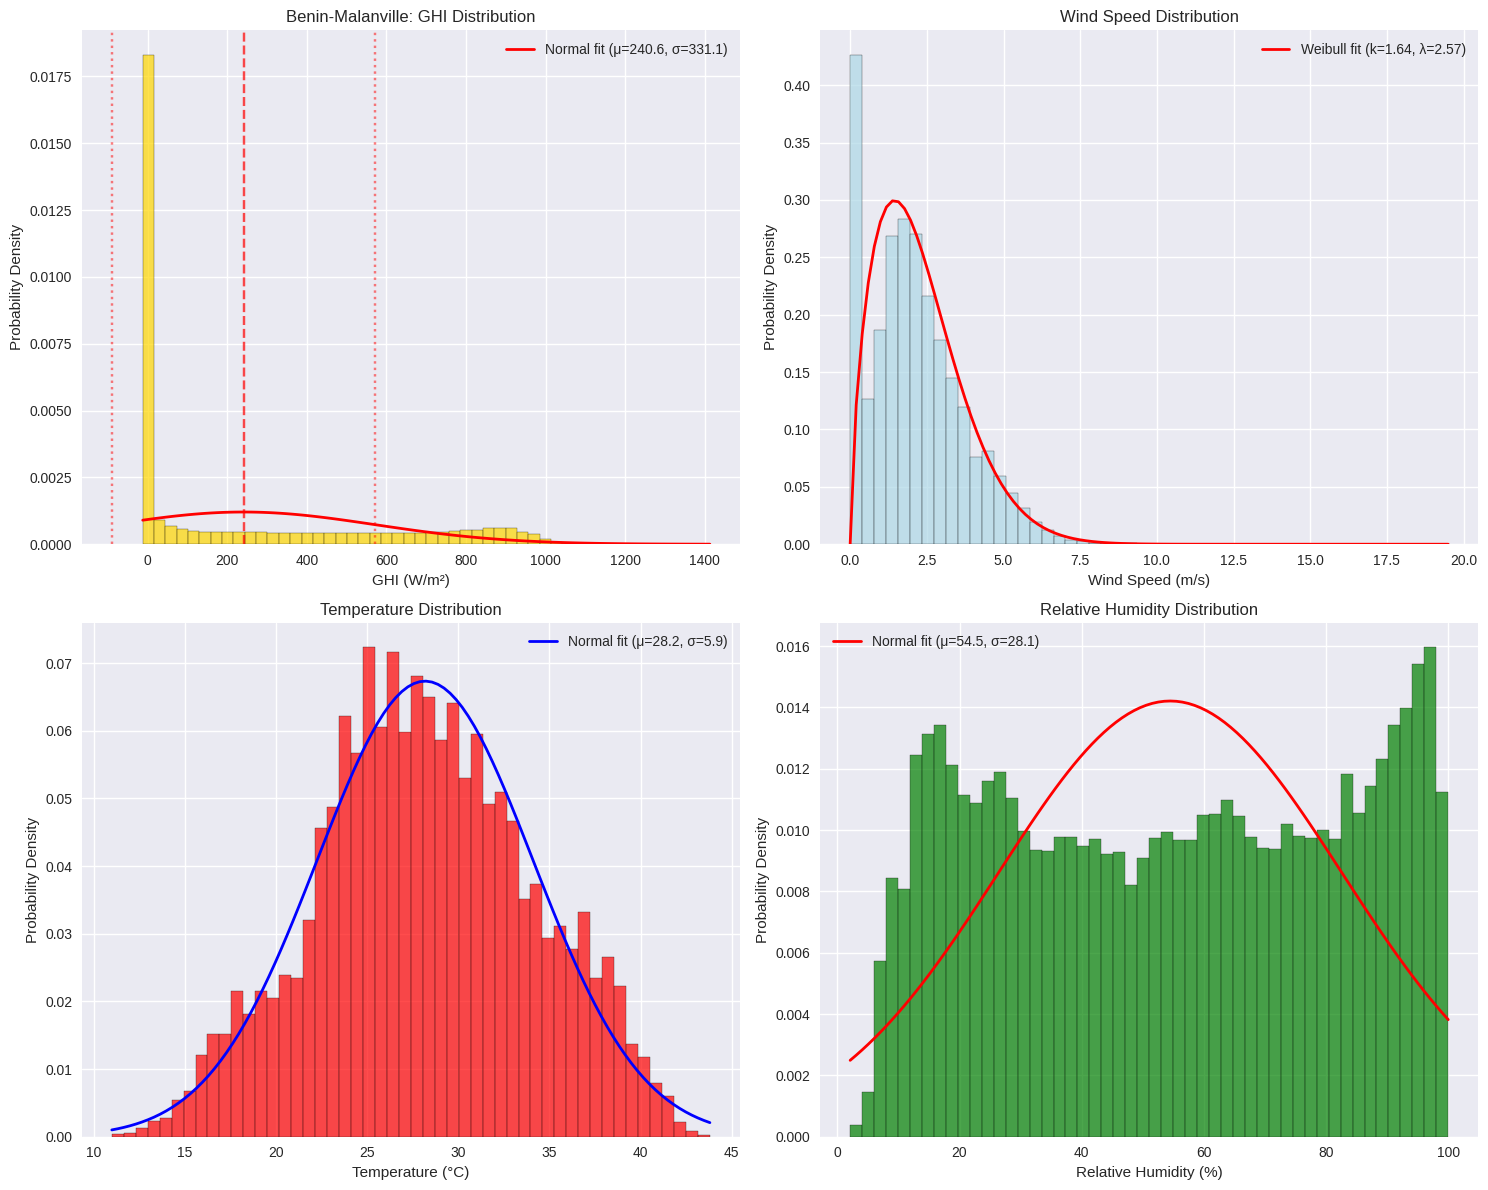


🎯 WIND ROSE ANALYSIS (Simulated)


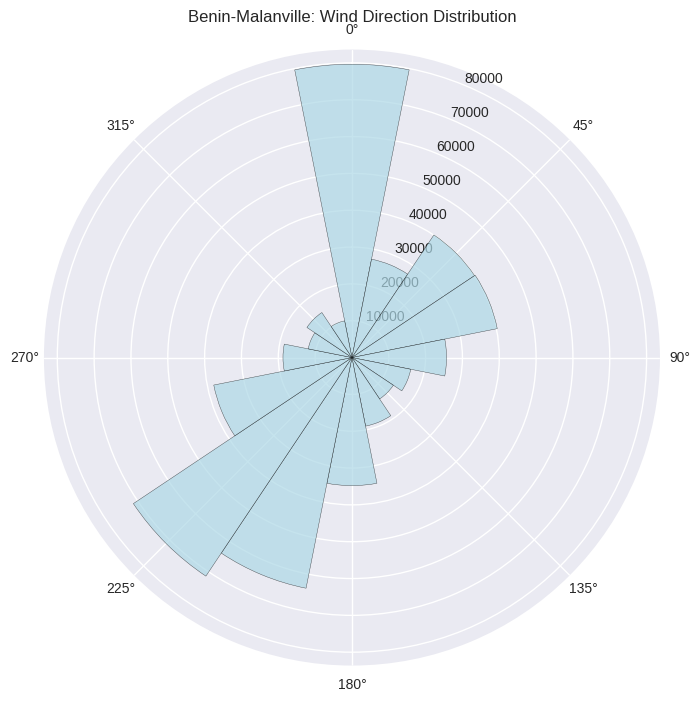

In [21]:
def wind_distribution_analysis(df):
    """Analyze wind patterns and distributions"""

    print("\n" + "=" * 60)
    print(" WIND & DISTRIBUTION ANALYSIS")
    print("=" * 60)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # GHI Distribution with normal fit
    if 'GHI' in df.columns:
        ghi_data = df['GHI'].dropna()
        axes[0,0].hist(ghi_data, bins=50, density=True, alpha=0.7, color='gold', edgecolor='black')
        axes[0,0].set_xlabel('GHI (W/m²)')
        axes[0,0].set_ylabel('Probability Density')
        axes[0,0].set_title('Benin-Malanville: GHI Distribution')

        # Fit normal distribution
        mu, sigma = stats.norm.fit(ghi_data)
        x = np.linspace(ghi_data.min(), ghi_data.max(), 100)
        pdf = stats.norm.pdf(x, mu, sigma)
        axes[0,0].plot(x, pdf, 'r-', linewidth=2, label=f'Normal fit (μ={mu:.1f}, σ={sigma:.1f})')
        axes[0,0].legend()

        # Add statistical annotations
        axes[0,0].axvline(mu, color='red', linestyle='--', alpha=0.7)
        axes[0,0].axvline(mu + sigma, color='red', linestyle=':', alpha=0.5)
        axes[0,0].axvline(mu - sigma, color='red', linestyle=':', alpha=0.5)

    # Wind Speed Distribution
    if 'WS' in df.columns:
        ws_data = df['WS'].dropna()
        axes[0,1].hist(ws_data, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
        axes[0,1].set_xlabel('Wind Speed (m/s)')
        axes[0,1].set_ylabel('Probability Density')
        axes[0,1].set_title('Wind Speed Distribution')

        # Fit Weibull distribution (common for wind speed)
        try:
            shape, loc, scale = stats.weibull_min.fit(ws_data, floc=0)
            x = np.linspace(ws_data.min(), ws_data.max(), 100)
            pdf = stats.weibull_min.pdf(x, shape, loc, scale)
            axes[0,1].plot(x, pdf, 'r-', linewidth=2,
                          label=f'Weibull fit (k={shape:.2f}, λ={scale:.2f})')
            axes[0,1].legend()
        except:
            # Fallback to normal distribution
            mu, sigma = stats.norm.fit(ws_data)
            x = np.linspace(ws_data.min(), ws_data.max(), 100)
            pdf = stats.norm.pdf(x, mu, sigma)
            axes[0,1].plot(x, pdf, 'r-', linewidth=2, label=f'Normal fit (μ={mu:.2f}, σ={sigma:.2f})')
            axes[0,1].legend()

    # Temperature Distribution
    if 'Tamb' in df.columns:
        tamb_data = df['Tamb'].dropna()
        axes[1,0].hist(tamb_data, bins=50, density=True, alpha=0.7, color='red', edgecolor='black')
        axes[1,0].set_xlabel('Temperature (°C)')
        axes[1,0].set_ylabel('Probability Density')
        axes[1,0].set_title('Temperature Distribution')

        # Fit normal distribution
        mu, sigma = stats.norm.fit(tamb_data)
        x = np.linspace(tamb_data.min(), tamb_data.max(), 100)
        pdf = stats.norm.pdf(x, mu, sigma)
        axes[1,0].plot(x, pdf, 'b-', linewidth=2, label=f'Normal fit (μ={mu:.1f}, σ={sigma:.1f})')
        axes[1,0].legend()

    # RH Distribution
    if 'RH' in df.columns:
        rh_data = df['RH'].dropna()
        axes[1,1].hist(rh_data, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
        axes[1,1].set_xlabel('Relative Humidity (%)')
        axes[1,1].set_ylabel('Probability Density')
        axes[1,1].set_title('Relative Humidity Distribution')

        # Fit beta distribution (bounded between 0-100)
        try:
            a, b, loc, scale = stats.beta.fit(rh_data/100, floc=0, fscale=1)
            x = np.linspace(0, 1, 100)
            pdf = stats.beta.pdf(x, a, b, loc, scale)
            axes[1,1].plot(x*100, pdf/100, 'r-', linewidth=2,
                          label=f'Beta fit (α={a:.2f}, β={b:.2f})')
            axes[1,1].legend()
        except:
            # Fallback to normal
            mu, sigma = stats.norm.fit(rh_data)
            x = np.linspace(rh_data.min(), rh_data.max(), 100)
            pdf = stats.norm.pdf(x, mu, sigma)
            axes[1,1].plot(x, pdf, 'r-', linewidth=2, label=f'Normal fit (μ={mu:.1f}, σ={sigma:.1f})')
            axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    # Wind rose simulation (if we have wind direction)
    if 'WD' in df.columns:
        print("\n🎯 WIND ROSE ANALYSIS (Simulated)")
        # Create simplified wind rose
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

        # Group wind directions into sectors
        wd_data = df['WD'].dropna()
        if len(wd_data) > 0:
            sectors = np.linspace(0, 2*np.pi, 17)  # 16 sectors
            sector_counts, _ = np.histogram(wd_data * np.pi/180, bins=sectors)

            # Plot wind rose
            bars = ax.bar(sectors[:-1], sector_counts, width=2*np.pi/16,
                         alpha=0.7, color='lightblue', edgecolor='black')
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_title('Benin-Malanville: Wind Direction Distribution', pad=20)
            plt.show()

# Run wind and distribution analysis
if df_benin is not None:
    wind_distribution_analysis(df_clean)


TEMPERATURE & HUMIDITY ANALYSIS


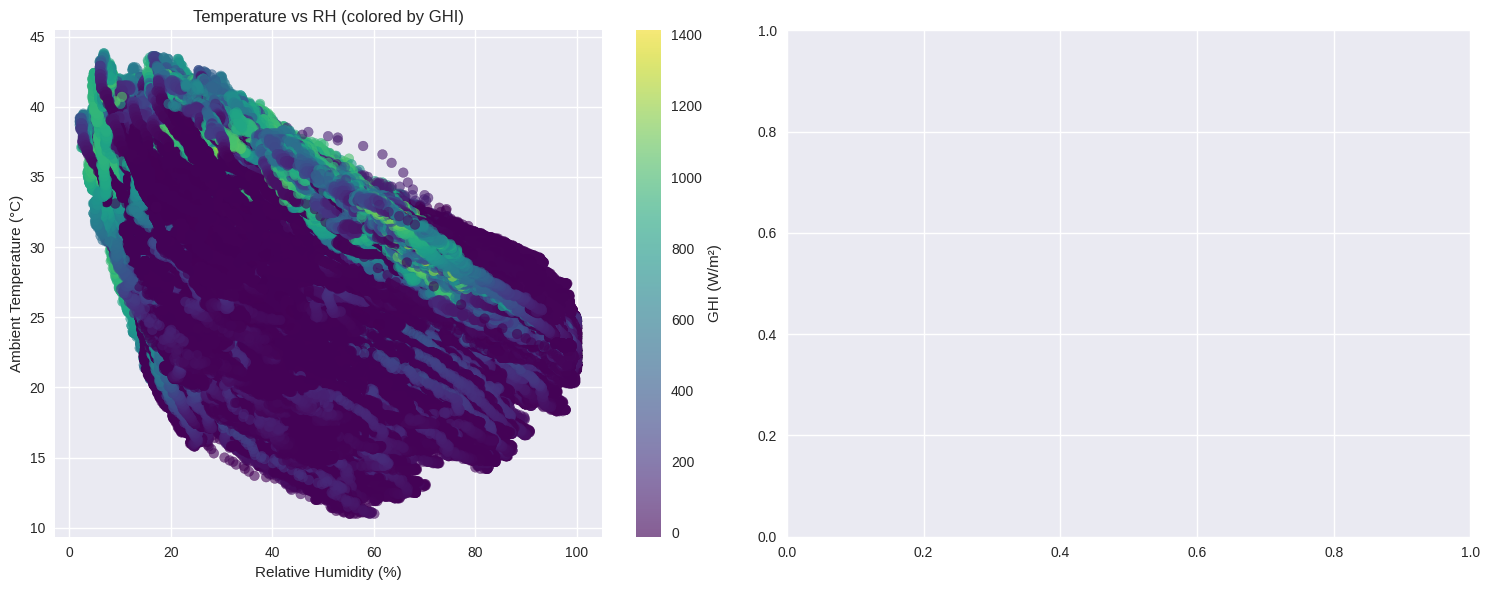


 RH-Temperature Correlation: r = -0.415


In [22]:
def temperature_humidity_analysis(df):
    """Analyze temperature and humidity relationships"""

    print("\n" + "=" * 60)
    print("TEMPERATURE & HUMIDITY ANALYSIS")
    print("=" * 60)

    if 'Tamb' not in df.columns or 'RH' not in df.columns:
        print(" Temperature or RH data not available for analysis")
        return

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # RH vs Temperature scatter with GHI coloring
    if 'GHI' in df.columns:
        scatter = axes[0].scatter(df['RH'], df['Tamb'], c=df['GHI'],
                                 alpha=0.6, cmap='viridis')
        axes[0].set_xlabel('Relative Humidity (%)')
        axes[0].set_ylabel('Ambient Temperature (°C)')
        axes[0].set_title('Temperature vs RH (colored by GHI)')
        plt.colorbar(scatter, ax=axes[0], label='GHI (W/m²)')
    else:
        axes[0].scatter(df['RH'], df['Tamb'], alpha=0.6)
        axes[0].set_xlabel('Relative Humidity (%)')
        axes[0].set_ylabel('Ambient Temperature (°C)')
        axes[0].set_title('Temperature vs RH')

    # Diurnal pattern of RH and Temperature
    if hasattr(df.index, 'hour'):
        diurnal_rh = df.groupby(df.index.hour)['RH'].mean()
        diurnal_temp = df.groupby(df.index.hour)['Tamb'].mean()

        ax2 = axes[1]
        ax2.plot(diurnal_rh.index, diurnal_rh.values, 'g-', linewidth=2, label='RH')
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Relative Humidity (%)', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        ax2_temp = ax2.twinx()
        ax2_temp.plot(diurnal_temp.index, diurnal_temp.values, 'r-', linewidth=2, label='Temperature')
        ax2_temp.set_ylabel('Temperature (°C)', color='red')
        ax2_temp.tick_params(axis='y', labelcolor='red')

        axes[1].set_title('Diurnal Patterns: RH vs Temperature')
        # Combined legend
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_temp.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

    # Statistical analysis of RH-Temperature relationship
    rh_temp_corr = df['RH'].corr(df['Tamb'])
    print(f"\n RH-Temperature Correlation: r = {rh_temp_corr:.3f}")

    if rh_temp_corr < -0.5:
        print(" Insight: Strong negative correlation - typical of many climates")
    elif rh_temp_corr > 0.5:
        print(" Insight: Unusual positive correlation - may indicate specific local conditions")

# Run temperature analysis
if df_benin is not None:
    temperature_humidity_analysis(df_clean)


🫧 BUBBLE CHART: MULTIVARIATE ANALYSIS


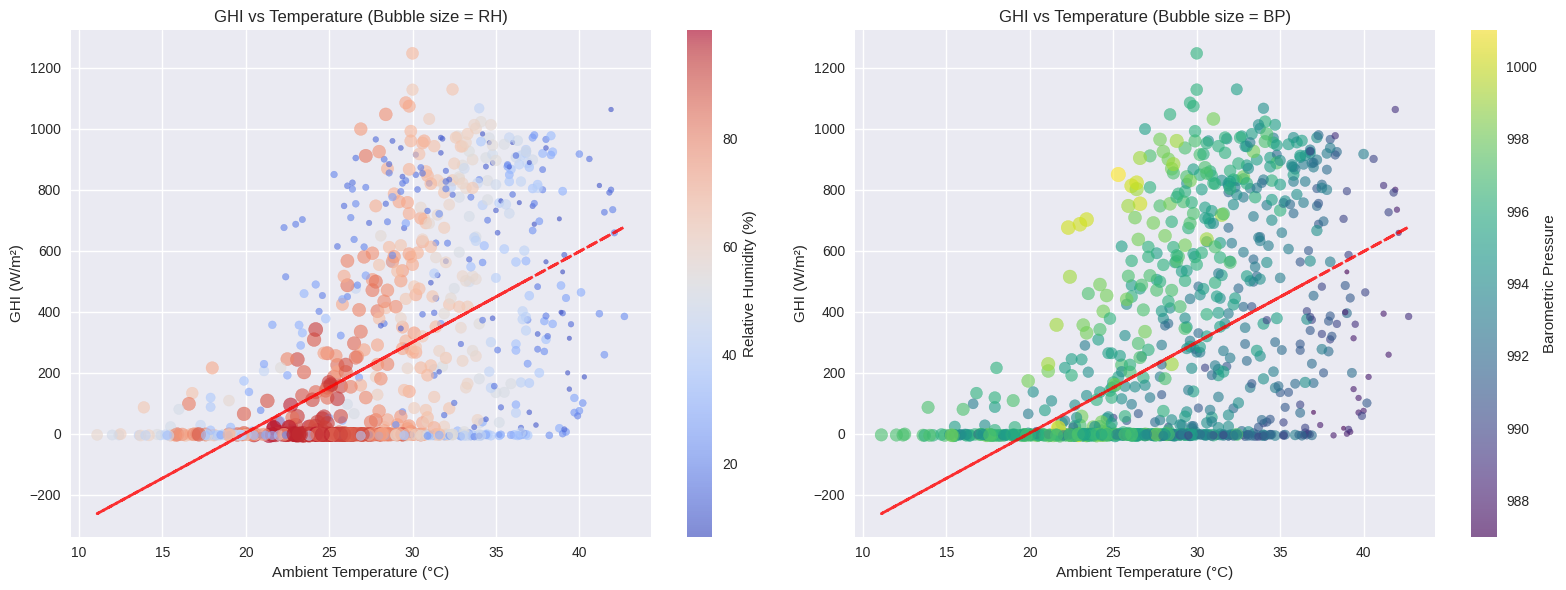

In [25]:
def create_bubble_chart(df):
    """Create bubble chart for multivariate analysis"""

    print("\n" + "=" * 60)
    print("🫧 BUBBLE CHART: MULTIVARIATE ANALYSIS")
    print("=" * 60)

    if 'GHI' not in df.columns or 'Tamb' not in df.columns:
        print(" GHI or Temperature data not available for bubble chart")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bubble chart 1: GHI vs Tamb with RH as bubble size
    if 'RH' in df.columns:
        # Sample data if too large for performance
        if len(df) > 1000:
            plot_df = df.sample(1000, random_state=42)
        else:
            plot_df = df

        bubble_size = (plot_df['RH'] - plot_df['RH'].min()) / (plot_df['RH'].max() - plot_df['RH'].min()) * 100 + 10

        scatter1 = ax1.scatter(plot_df['Tamb'], plot_df['GHI'], s=bubble_size,
                              c=plot_df['RH'], alpha=0.6, cmap='coolwarm')
        ax1.set_xlabel('Ambient Temperature (°C)')
        ax1.set_ylabel('GHI (W/m²)')
        ax1.set_title('GHI vs Temperature (Bubble size = RH)')
        cbar1 = plt.colorbar(scatter1, ax=ax1)
        cbar1.set_label('Relative Humidity (%)')

        # Add trend line
        z = np.polyfit(plot_df['Tamb'], plot_df['GHI'], 1)
        p = np.poly1d(z)
        ax1.plot(plot_df['Tamb'], p(plot_df['Tamb']), "r--", alpha=0.8, linewidth=2)

    # Bubble chart 2: GHI vs Tamb with BP as bubble size
    if 'BP' in df.columns:
        if len(df) > 1000:
            plot_df = df.sample(1000, random_state=42)
        else:
            plot_df = df

        bubble_size2 = (plot_df['BP'] - plot_df['BP'].min()) / (plot_df['BP'].max() - plot_df['BP'].min()) * 100 + 10

        scatter2 = ax2.scatter(plot_df['Tamb'], plot_df['GHI'], s=bubble_size2,
                              c=plot_df['BP'], alpha=0.6, cmap='viridis')
        ax2.set_xlabel('Ambient Temperature (°C)')
        ax2.set_ylabel('GHI (W/m²)')
        ax2.set_title('GHI vs Temperature (Bubble size = BP)')
        cbar2 = plt.colorbar(scatter2, ax=ax2)
        cbar2.set_label('Barometric Pressure')

        # Add trend line
        z = np.polyfit(plot_df['Tamb'], plot_df['GHI'], 1)
        p = np.poly1d(z)
        ax2.plot(plot_df['Tamb'], p(plot_df['Tamb']), "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.show()

# Create bubble charts
if df_benin is not None:
    create_bubble_chart(df_clean)

In [29]:
def export_data_and_generate_report(df_clean, original_df):
    """Export cleaned data and generate final insights report"""

    print("\n" + "=" * 60)
    print(" EXPORTING CLEANED DATA & GENERATING INSIGHTS")
    print("=" * 60)

    # Export cleaned data
    df_clean.to_csv('benin-malanville_clean.csv', index=False)
    print(" Cleaned data exported to: data/benin-malanville_clean.csv")

    # Generate comprehensive insights report
    print("\n" + "=" * 60)
    print(" BENIN-MALANVILLE SOLAR DATA INSIGHTS REPORT")
    print("=" * 60)

    insights = []

    # Data Quality Insights
    if 'cleaning_flag' in df_clean.columns:
        cleaned_pct = (df_clean['cleaning_flag'].sum() / len(df_clean)) * 100
        insights.append(" DATA QUALITY:")
        insights.append(f"  • {cleaned_pct:.1f}% of rows contained outliers or required cleaning")
        insights.append(f"  • Final dataset: {len(df_clean)} rows, {len(df_clean.columns)} columns")

    # Solar Resource Assessment
    if 'GHI' in df_clean.columns:
        avg_ghi = df_clean['GHI'].mean()
        std_ghi = df_clean['GHI'].std()

        insights.append("\n SOLAR RESOURCE ASSESSMENT:")
        insights.append(f"  • Average GHI: {avg_ghi:.1f} ± {std_ghi:.1f} W/m²")

        # Solar potential classification
        if avg_ghi > 600:
            insights.append("  •  EXCELLENT: Ideal for utility-scale solar projects")
        elif avg_ghi > 500:
            insights.append("  •  VERY GOOD: Suitable for large-scale PV installations")
        elif avg_ghi > 400:
            insights.append("  •  GOOD: Appropriate for commercial and industrial PV")
        else:
            insights.append("  • MODERATE: Consider technology optimization")

    # Climate Conditions
    if 'Tamb' in df_clean.columns:
        avg_temp = df_clean['Tamb'].mean()
        max_temp = df_clean['Tamb'].max()

        insights.append("\n CLIMATE CONDITIONS:")
        insights.append(f"  • Average temperature: {avg_temp:.1f}°C")
        insights.append(f"  • Maximum temperature: {max_temp:.1f}°C")

        if avg_temp > 30:
            insights.append("  •  High temperatures may reduce PV efficiency")
            insights.append("  •  Recommendation: Use temperature-optimized panels")

    # Wind Assessment
    if 'WS' in df_clean.columns:
        avg_ws = df_clean['WS'].mean()
        max_ws = df_clean['WS'].max()

        insights.append("\n WIND CONDITIONS:")
        insights.append(f"  • Average wind speed: {avg_ws:.1f} m/s")
        insights.append(f"  • Maximum wind speed: {max_ws:.1f} m/s")

        if avg_ws > 4:
            insights.append("  •  Good natural cooling potential for PV modules")

    # Humidity Insights
    if 'RH' in df_clean.columns:
        avg_rh = df_clean['RH'].mean()
        insights.append("\n HUMIDITY CONDITIONS:")
        insights.append(f"  • Average relative humidity: {avg_rh:.1f}%")

        if avg_rh > 70:
            insights.append("  •  High humidity - monitor for potential soiling effects")

    # Correlation Insights
    if all(col in df_clean.columns for col in ['GHI', 'Tamb', 'RH']):
        ghi_temp_corr = df_clean['GHI'].corr(df_clean['Tamb'])
        ghi_rh_corr = df_clean['GHI'].corr(df_clean['RH'])

        insights.append("\n KEY RELATIONSHIPS:")
        insights.append(f"  • GHI-Temperature correlation: {ghi_temp_corr:.3f}")
        insights.append(f"  • GHI-Humidity correlation: {ghi_rh_corr:.3f}")

        if ghi_temp_corr > 0.3:
            insights.append("  •  Temperature positively influences solar radiation")
        if ghi_rh_corr < -0.3:
            insights.append("  •  Humidity negatively affects solar radiation")

    # Print all insights
    for insight in insights:
        print(insight)

    # Final recommendations
    print("\n KEY RECOMMENDATIONS FOR BENIN-MALANVILLE:")
    print("• Consider seasonal variations in system design and sizing")
    print("• Monitor temperature effects on panel efficiency")
    print("• Account for humidity impacts on system performance")
    print("• Use cleaned dataset for accurate solar potential assessment")
    print("• Consider local climate patterns in maintenance scheduling")

# Export and generate report
if df_benin is not None:
    export_data_and_generate_report(df_clean, df_benin)


 EXPORTING CLEANED DATA & GENERATING INSIGHTS
 Cleaned data exported to: data/benin-malanville_clean.csv

 BENIN-MALANVILLE SOLAR DATA INSIGHTS REPORT
 DATA QUALITY:
  • 1.6% of rows contained outliers or required cleaning
  • Final dataset: 525600 rows, 20 columns

 SOLAR RESOURCE ASSESSMENT:
  • Average GHI: 240.6 ± 331.1 W/m²
  • MODERATE: Consider technology optimization

 CLIMATE CONDITIONS:
  • Average temperature: 28.2°C
  • Maximum temperature: 43.8°C

 WIND CONDITIONS:
  • Average wind speed: 2.1 m/s
  • Maximum wind speed: 19.5 m/s

 HUMIDITY CONDITIONS:
  • Average relative humidity: 54.5%

 KEY RELATIONSHIPS:
  • GHI-Temperature correlation: 0.548
  • GHI-Humidity correlation: -0.360
  •  Temperature positively influences solar radiation
  •  Humidity negatively affects solar radiation

 KEY RECOMMENDATIONS FOR BENIN-MALANVILLE:
• Consider seasonal variations in system design and sizing
• Monitor temperature effects on panel efficiency
• Account for humidity impacts on sys

 STARTING COMPLETE BENIN-MALANVILLE SOLAR DATA EDA
🇧🇯 BENIN-MALANVILLE SOLAR DATA EDA
 Dataset loaded successfully: (525600, 19)

 DATASET OVERVIEW:
   Shape: (525600, 19)
   Columns: 19

 COLUMN NAMES:
['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']

 DATA TYPES:
Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object

 SAMPLE DATA (first 3 rows):
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-08-09 0

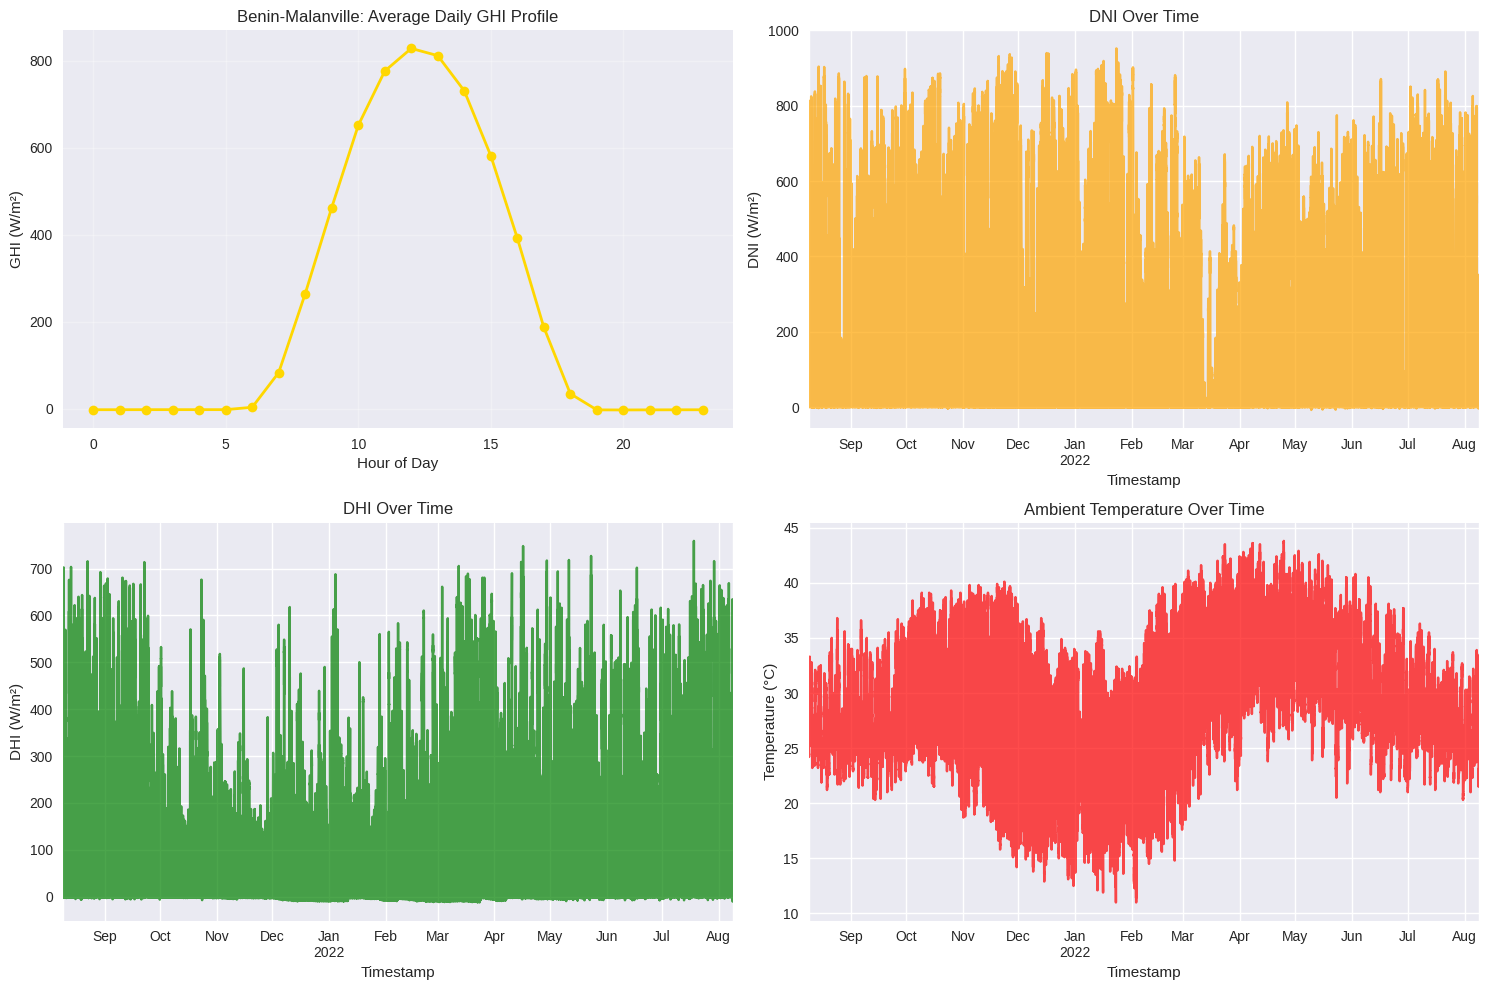

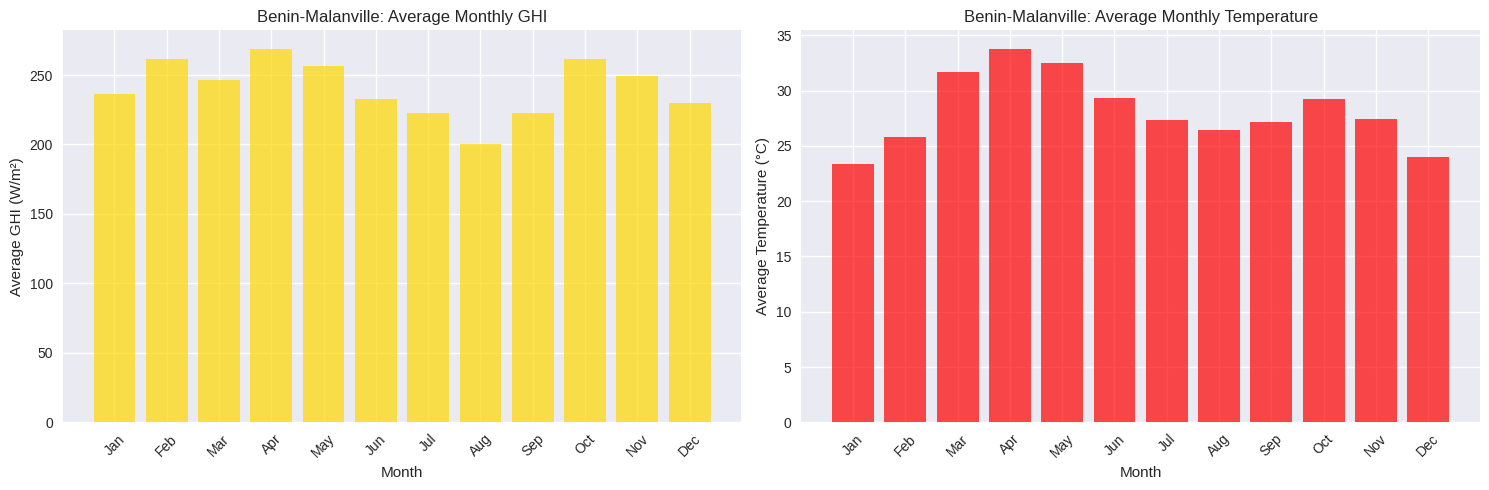


 CLEANING IMPACT ANALYSIS


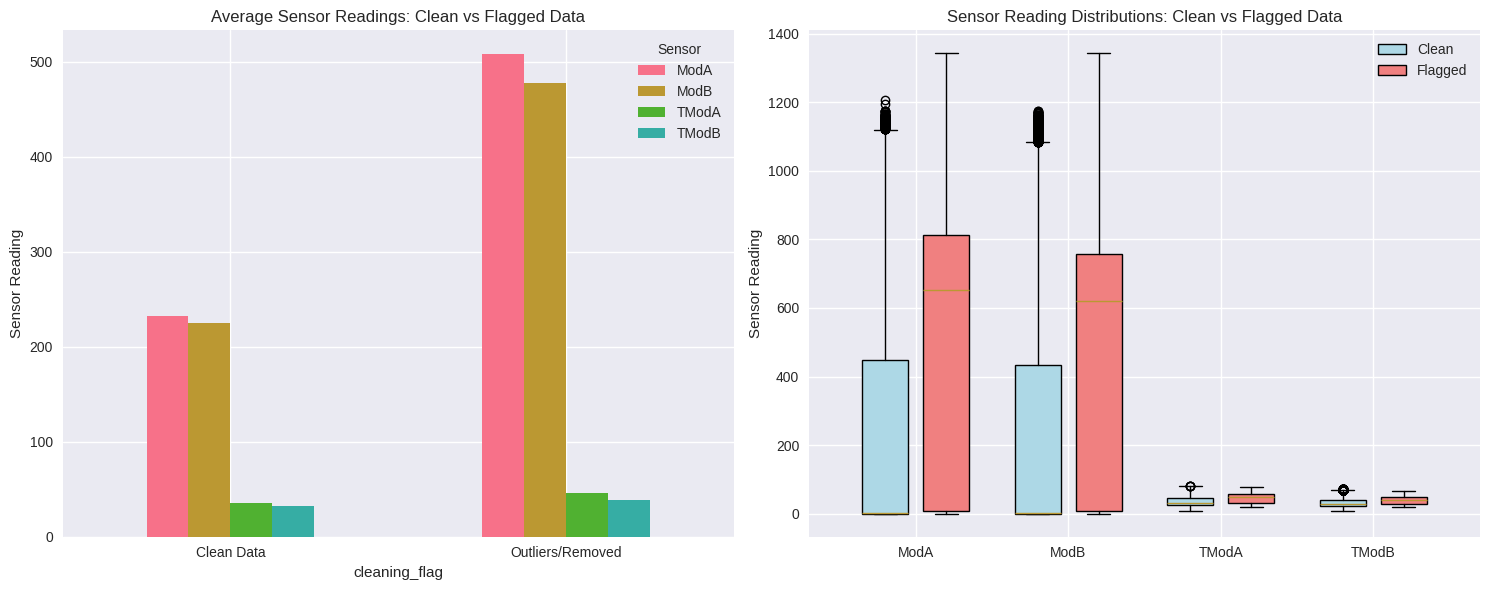


 STATISTICAL COMPARISON (Clean vs Flagged Data):
   ModA: Clean=232.11, Flagged=507.48, Diff=+118.6%
   ModB: Clean=224.77, Flagged=477.74, Diff=+112.5%
   TModA: Clean=35.08, Flagged=45.57, Diff=+29.9%
   TModB: Clean=32.36, Flagged=38.94, Diff=+20.3%

 CORRELATION & RELATIONSHIP ANALYSIS


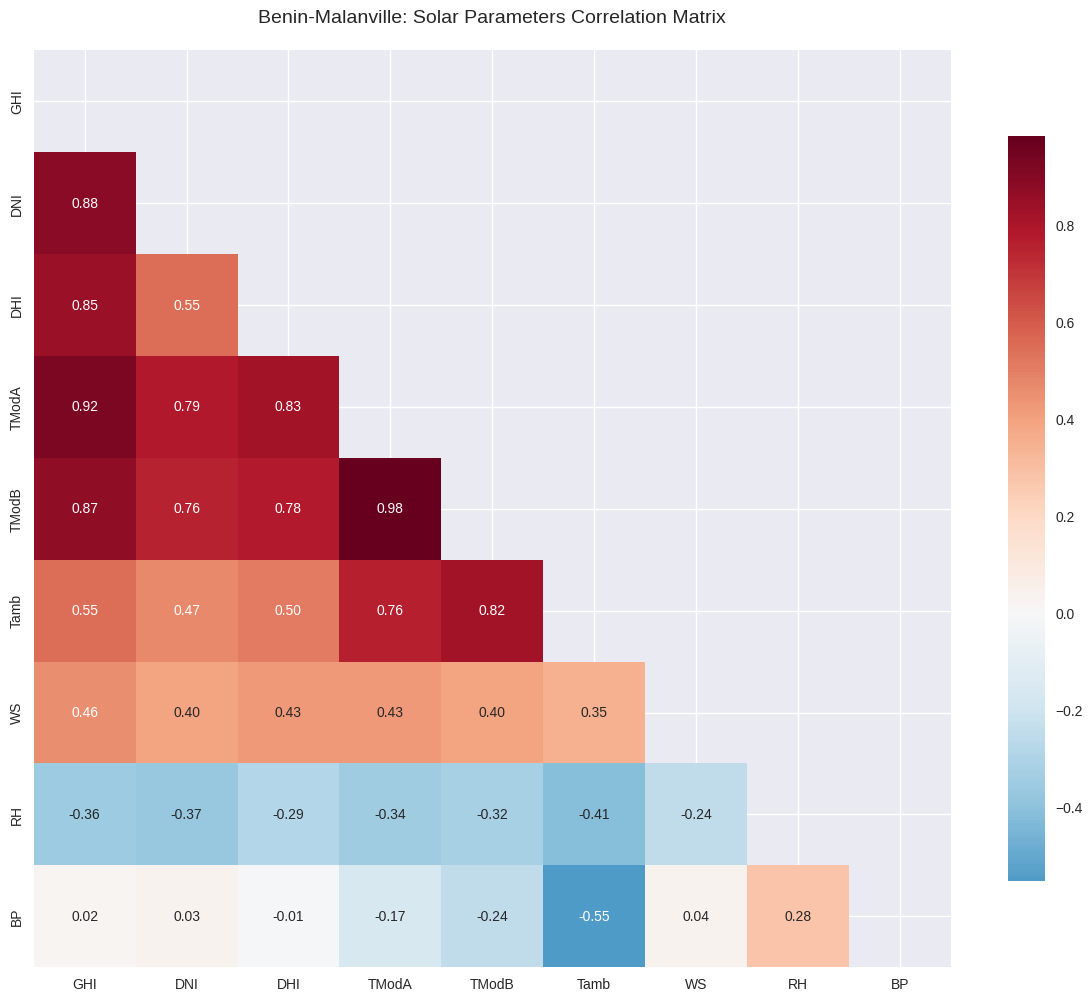

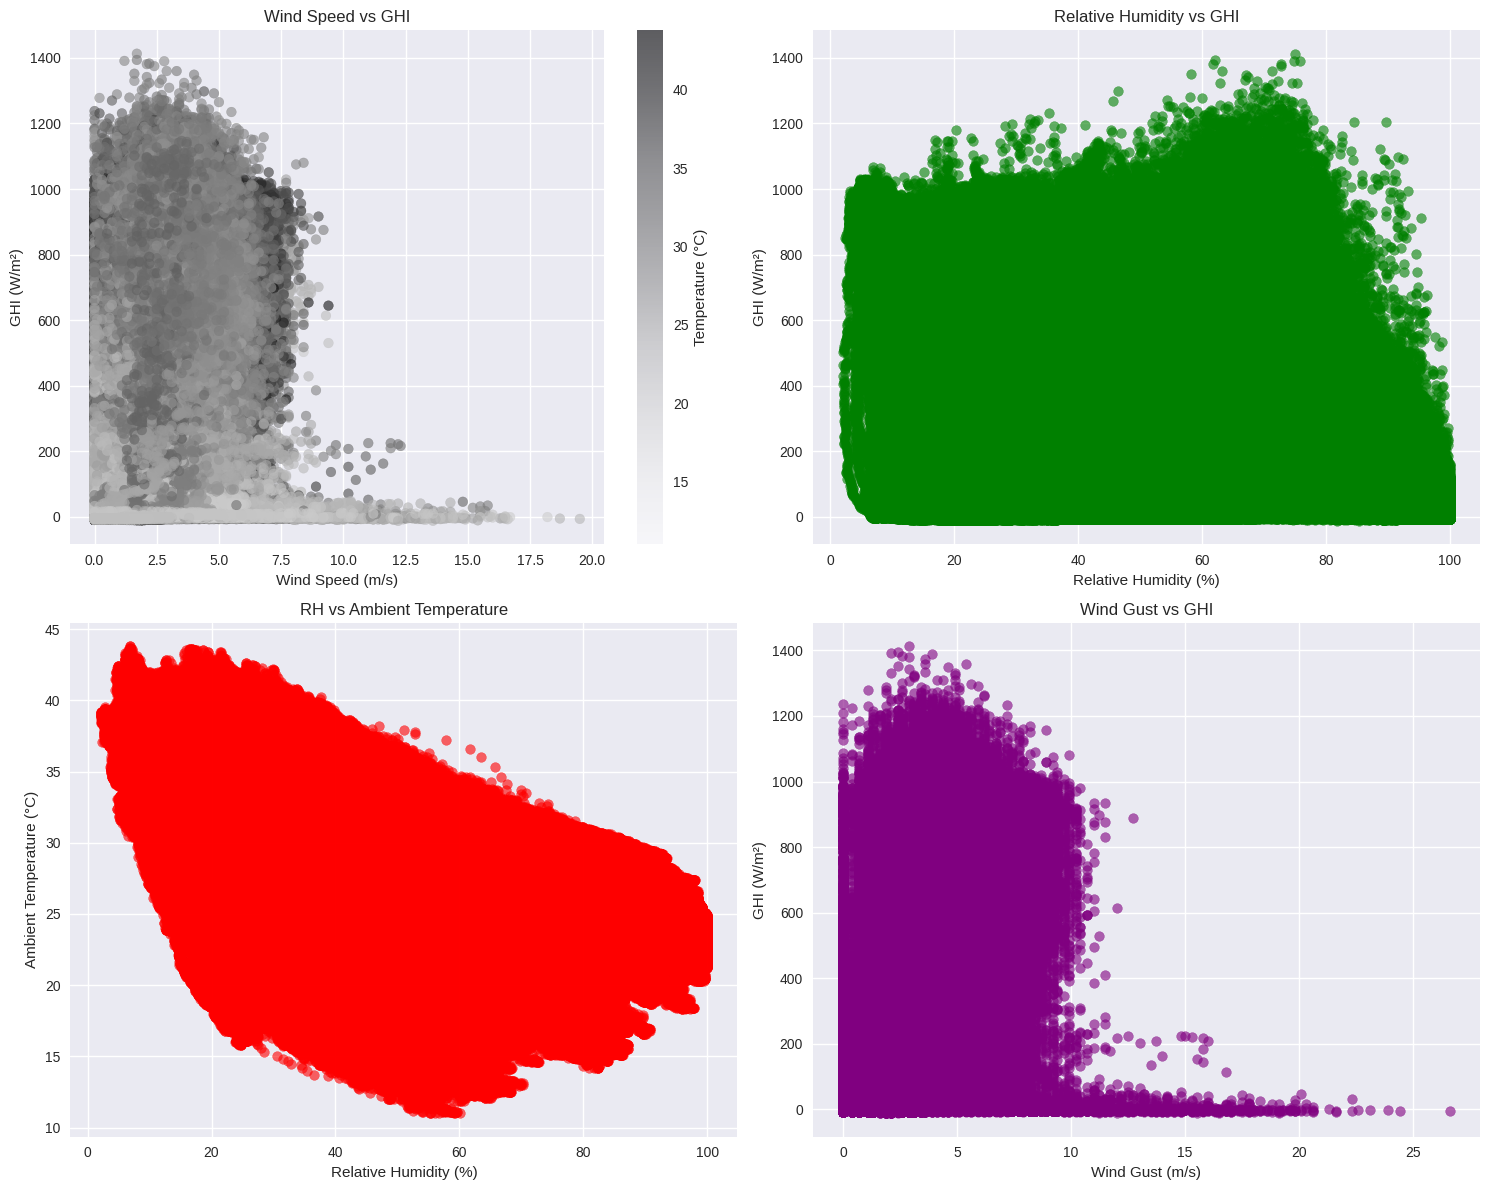


💡 STRONG CORRELATIONS (|r| > 0.7):
   GHI vs DNI: r = 0.882
   GHI vs DHI: r = 0.850
   GHI vs TModA: r = 0.920
   GHI vs TModB: r = 0.874
   DNI vs TModA: r = 0.790
   DNI vs TModB: r = 0.756
   DHI vs TModA: r = 0.825
   DHI vs TModB: r = 0.778
   TModA vs TModB: r = 0.983
   TModA vs Tamb: r = 0.762
   TModB vs Tamb: r = 0.823

 WIND & DISTRIBUTION ANALYSIS


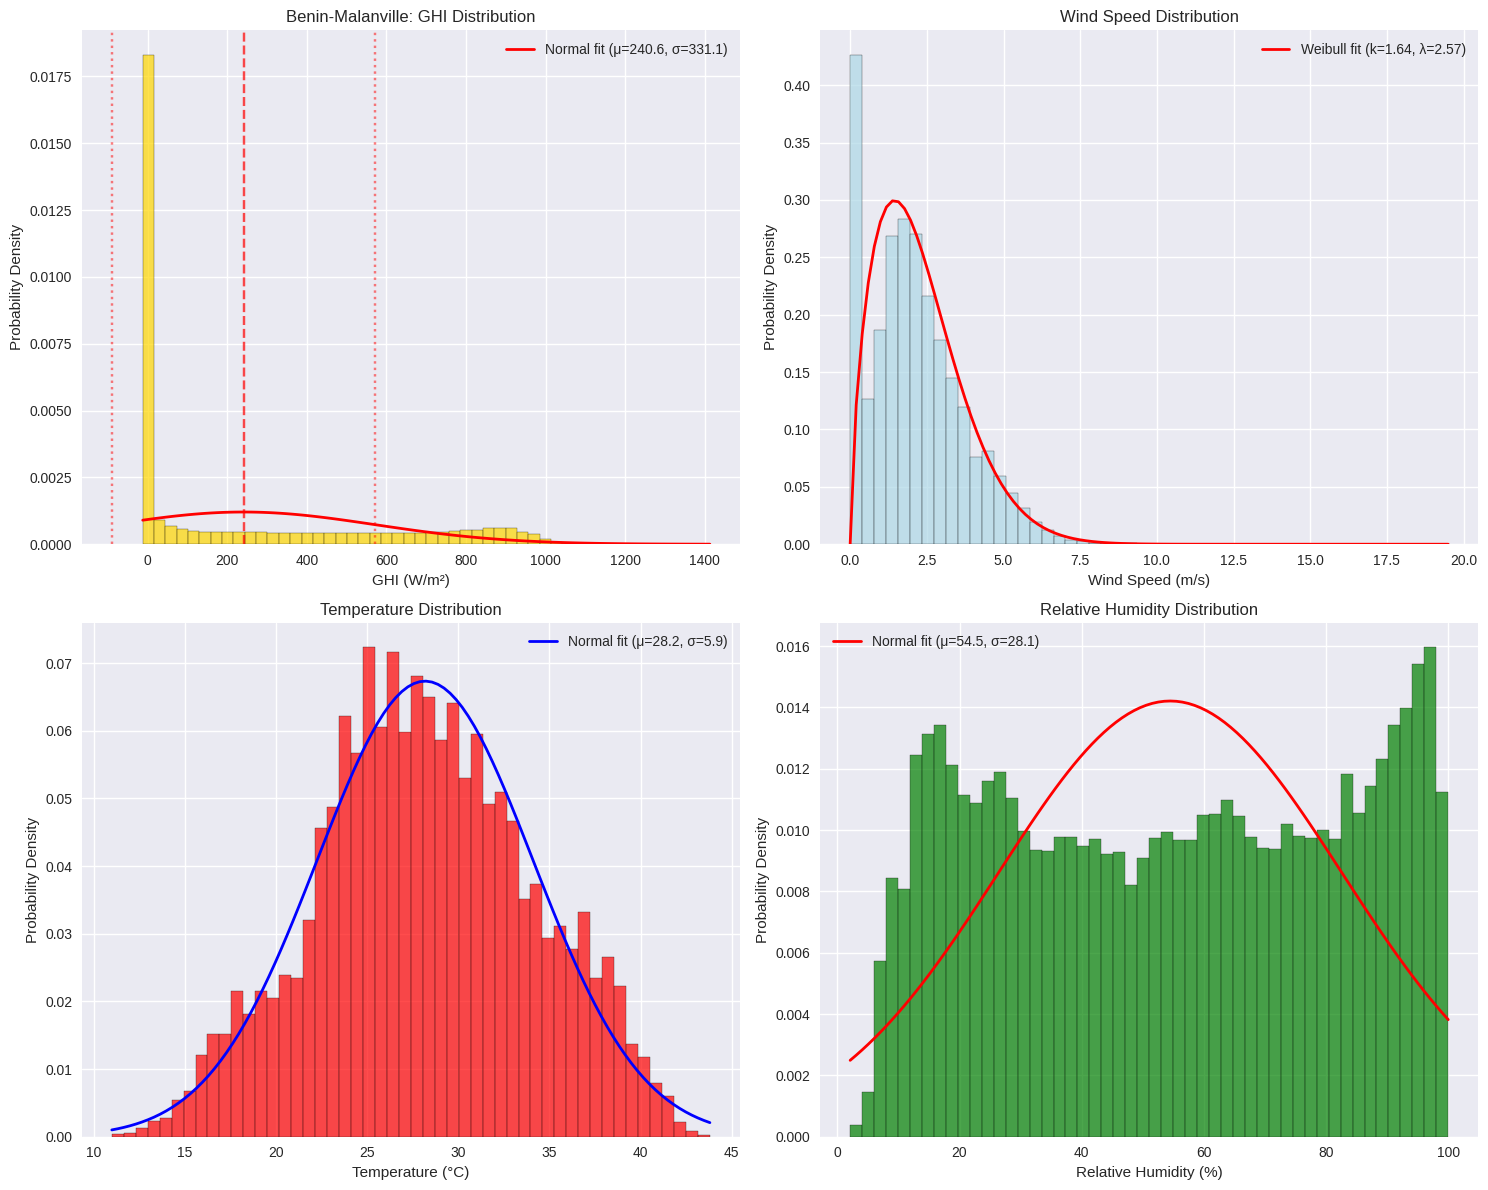


🎯 WIND ROSE ANALYSIS (Simulated)


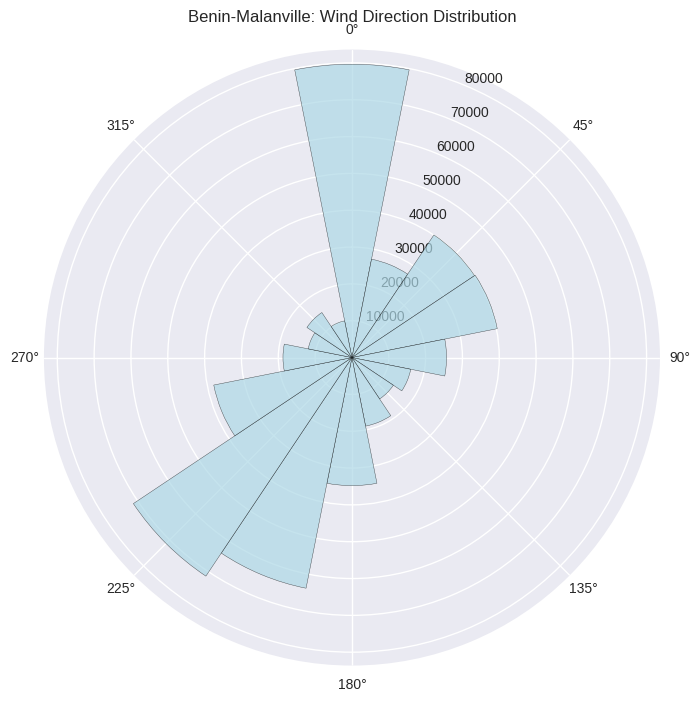


TEMPERATURE & HUMIDITY ANALYSIS


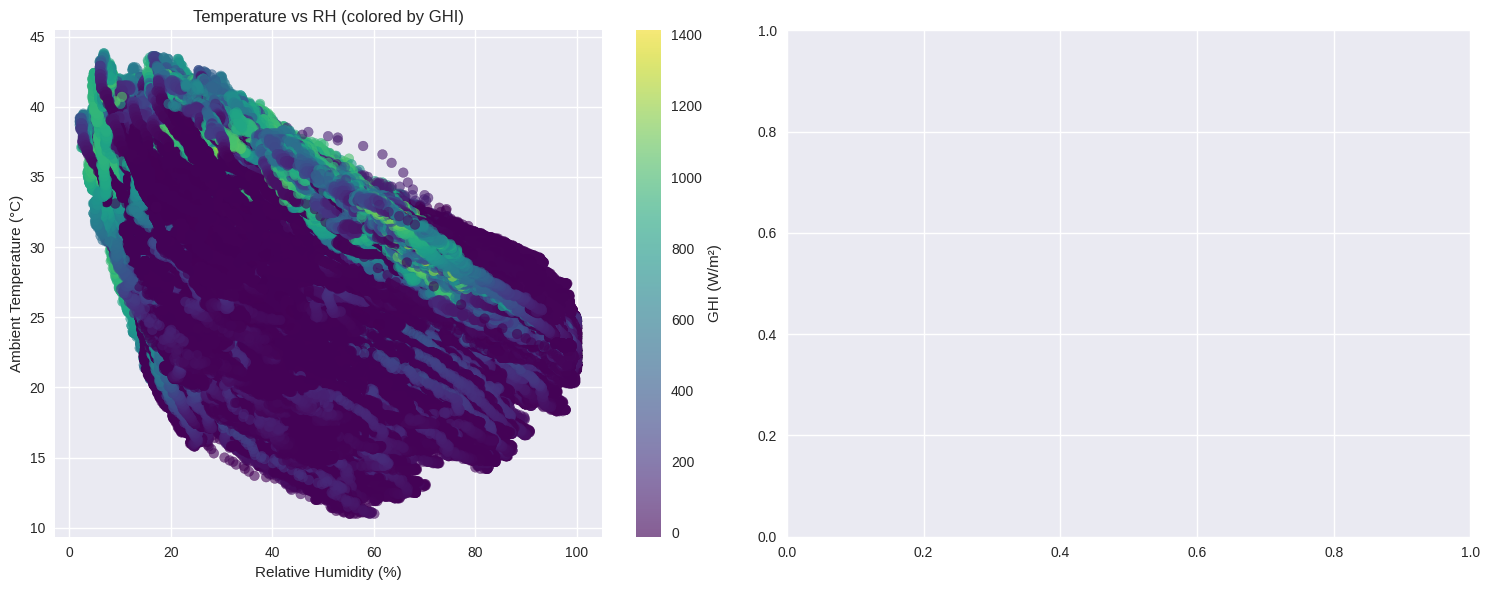


 RH-Temperature Correlation: r = -0.415

🫧 BUBBLE CHART: MULTIVARIATE ANALYSIS


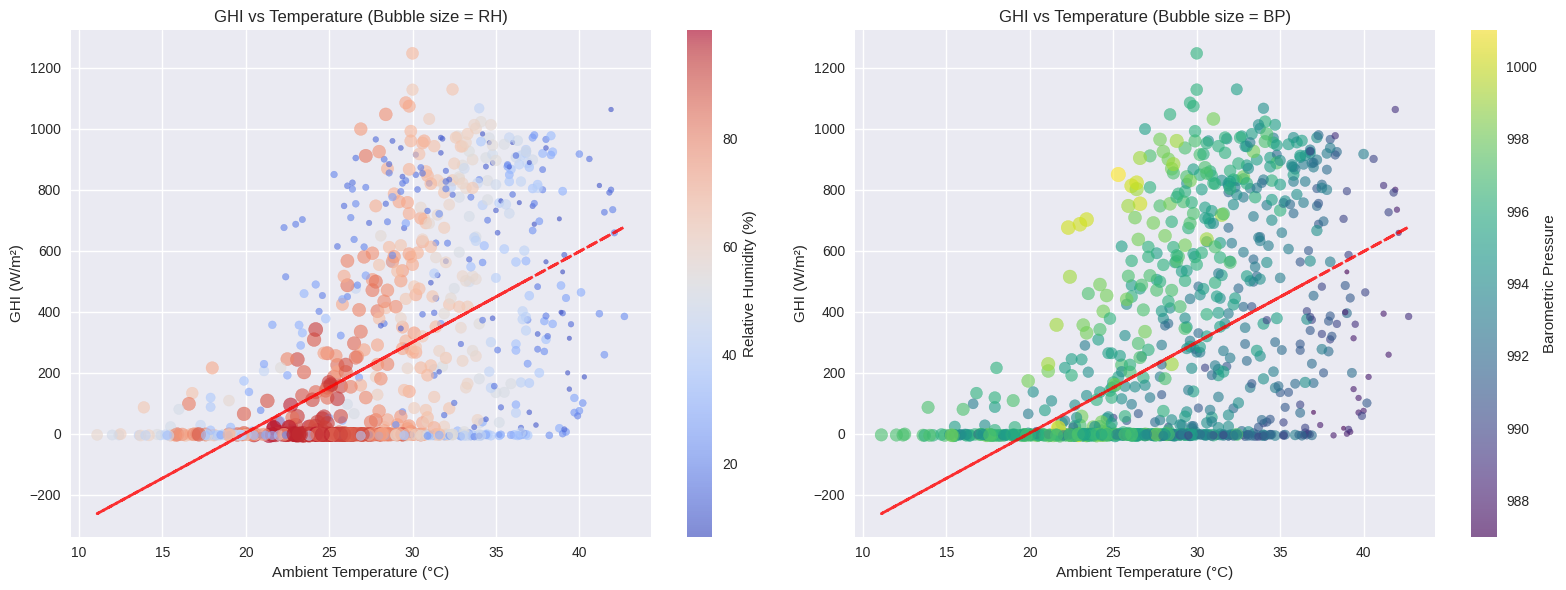


 EXPORTING CLEANED DATA & GENERATING INSIGHTS
 Cleaned data exported to: data/benin-malanville_clean.csv

 BENIN-MALANVILLE SOLAR DATA INSIGHTS REPORT
 DATA QUALITY:
  • 1.6% of rows contained outliers or required cleaning
  • Final dataset: 525600 rows, 20 columns

 SOLAR RESOURCE ASSESSMENT:
  • Average GHI: 240.6 ± 331.1 W/m²
  • MODERATE: Consider technology optimization

 CLIMATE CONDITIONS:
  • Average temperature: 28.2°C
  • Maximum temperature: 43.8°C

 WIND CONDITIONS:
  • Average wind speed: 2.1 m/s
  • Maximum wind speed: 19.5 m/s

 HUMIDITY CONDITIONS:
  • Average relative humidity: 54.5%

 KEY RELATIONSHIPS:
  • GHI-Temperature correlation: 0.548
  • GHI-Humidity correlation: -0.360
  •  Temperature positively influences solar radiation
  •  Humidity negatively affects solar radiation

 KEY RECOMMENDATIONS FOR BENIN-MALANVILLE:
• Consider seasonal variations in system design and sizing
• Monitor temperature effects on panel efficiency
• Account for humidity impacts on sys

In [30]:
# MAIN EXECUTION - RUN COMPLETE BENIN-MALANVILLE EDA
def run_complete_benin_malanville_eda():
    """Complete EDA pipeline for Benin-Malanville solar data"""

    print(" STARTING COMPLETE BENIN-MALANVILLE SOLAR DATA EDA")
    print("=" * 70)

    # 1. Load and profile data
    df_original = load_and_profile_benin_malanville()
    if df_original is None:
        print(" EDA failed: Could not load data")
        return

    # 2. Data profiling
    missing_report, numeric_cols = comprehensive_profiling(df_original)

    # 3. Outlier detection and cleaning
    df_clean, outlier_flags = detect_and_clean_outliers(df_original)

    # 4. Time series analysis
    time_series_analysis(df_clean)

    # 5. Cleaning impact analysis
    cleaning_impact_analysis(df_clean)

    # 6. Correlation analysis
    correlation_relationship_analysis(df_clean)

    # 7. Wind and distribution analysis
    wind_distribution_analysis(df_clean)

    # 8. Temperature and humidity analysis
    temperature_humidity_analysis(df_clean)

    # 9. Bubble chart visualization
    create_bubble_chart(df_clean)

    # 10. Export and generate final report
    export_data_and_generate_report(df_clean, df_original)

    print("\n BENIN-MALANVILLE EDA COMPLETED SUCCESSFULLY!")
    print(" Outputs generated:")
    print("   - Cleaned dataset: data/benin-malanville_clean.csv")
    print("   - Comprehensive visualizations and plots")
    print("   - Statistical analysis and insights report")
    print("   - Actionable recommendations for solar project planning")

# Run the complete EDA pipeline
run_complete_benin_malanville_eda()